In [1]:
import tensorflow as tf
import os
import scipy as sc

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip install opencv-python matplotlib

In [5]:
import cv2
import imghdr

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
data_dir = 'dataset_final'

In [8]:
data = tf.keras.utils.image_dataset_from_directory('dataset_final',label_mode='categorical')

Found 10661 files belonging to 3 classes.


In [9]:
print(os.listdir(data_dir))

['test_Prepro', 'train_Prepro', 'val_Prepro']


In [10]:
data_train = tf.keras.utils.image_dataset_from_directory('dataset_final/train_Prepro',label_mode='categorical')

Found 7461 files belonging to 6 classes.


In [11]:
data_test = tf.keras.utils.image_dataset_from_directory('dataset_final/test_Prepro',label_mode='categorical')

Found 1605 files belonging to 6 classes.


In [12]:
data_val = tf.keras.utils.image_dataset_from_directory('dataset_final/val_Prepro',label_mode='categorical')

Found 1595 files belonging to 6 classes.


In [13]:
train_dir='dataset_final/train_Prepro'
val_dir='dataset_final/val_Prepro'
test_dir='dataset_final/test_Prepro'

In [14]:
batch_size=64
from keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation and preprocessing pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,
rotation_range=20,  # randomly rotate the images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift the images horizontally by up to 20% of the width
    height_shift_range=0.2,  # randomly shift the images vertically by up to 20% of the height
    shear_range=0.2,  # randomly apply shearing transformations
    zoom_range=0.2,  # randomly zoom in or out on the images
    horizontal_flip=True,  # randomly flip the images horizontally
    fill_mode='nearest'  # fill in any missing pixels with the nearest available pixel
)

# Create the data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=True  # shuffle the data at the beginning of each epoch
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=False  # don't shuffle the validation data
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=False  # don't shuffle the test data
)


Found 7461 images belonging to 6 classes.
Found 1595 images belonging to 6 classes.
Found 1605 images belonging to 6 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [16]:
logdir='logs'

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,1)))
model.add(MaxPooling2D())
model.add(Dropout(0.15))  # add dropout after the first conv layer
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))  # add droout after the second conv layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))  # add dropout after the first dense layer
model.add(Dense(6, activation='softmax'))

In [19]:
model.compile('adam' , loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

In [22]:
hist = model.fit(train_generator, epochs=130, validation_data=val_generator, callbacks=[tensorboard_callback])

Epoch 1/130
117/117 [==============================] - 27s 227ms/step - loss: 0.5946 - accuracy: 0.7711 - val_loss: 2.8714 - val_accuracy: 0.5950
Epoch 2/130
117/117 [==============================] - 27s 229ms/step - loss: 0.5943 - accuracy: 0.7704 - val_loss: 1.9791 - val_accuracy: 0.6025
Epoch 3/130
117/117 [==============================] - 27s 227ms/step - loss: 0.5958 - accuracy: 0.7671 - val_loss: 1.3061 - val_accuracy: 0.6771
Epoch 4/130
117/117 [==============================] - 25s 217ms/step - loss: 0.5826 - accuracy: 0.7687 - val_loss: 2.0325 - val_accuracy: 0.6176
Epoch 5/130
117/117 [==============================] - 26s 220ms/step - loss: 0.5593 - accuracy: 0.7874 - val_loss: 2.0243 - val_accuracy: 0.6263
Epoch 6/130
117/117 [==============================] - 26s 218ms/step - loss: 0.5732 - accuracy: 0.7754 - val_loss: 2.2659 - val_accuracy: 0.6069
Epoch 7/130
117/117 [==============================] - 26s 218ms/step - loss: 0.5459 - accuracy: 0.7869 - val_loss: 1.9319 -

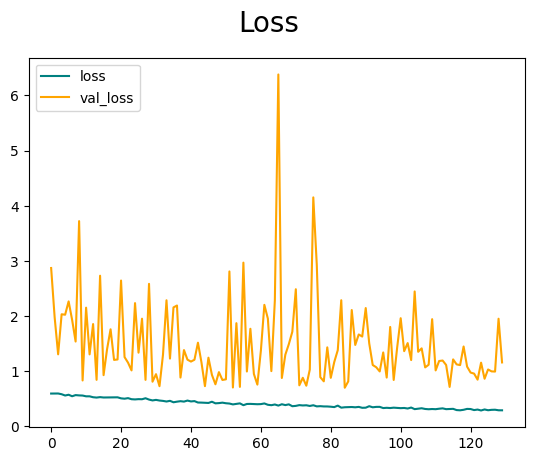

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

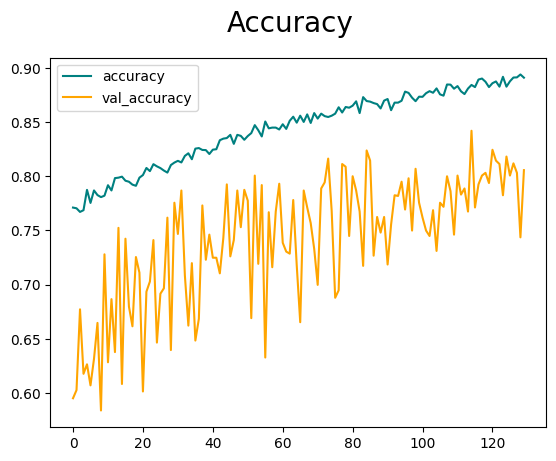

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [25]:
from keras.models import load_model

# Save the trained model with custom name "Keras"
model.save("Keras.h5")

# Load the saved model
loaded_model = load_model("Keras.h5")


In [26]:
# Test the model on the testing data
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

26/26 [==============================] - 2s 83ms/step - loss: 1.1991 - accuracy: 0.7938
Test loss: 1.1990758180618286
Test accuracy: 0.7937694787979126
